# Single-Cell RNA-seq Cell Annotation Pipeline

This notebook provides an interactive walkthrough of the complete cell annotation pipeline, from raw CellBender output to annotated cell types.

**Authors:** Tsai Lab  
**Last Updated:** 2025-01-11  
**Version:** 2.0 (Corrected to match original pipeline)

⚠️ **Important**: This notebook uses the exact calculation methods from the original pipeline to ensure reproducible results.

---

## Table of Contents

1. [Setup & Installation](#setup)
2. [Parameter Configuration](#parameters)
3. [Stage 1: Data Loading & Integration](#stage1)
4. [Stage 2: QC Metrics Calculation & Visualization](#stage2)
5. [Stage 3: Doublet Detection](#stage3)
6. [Stage 4: Cell & Gene Filtering](#stage4)
7. [Stage 5: Normalization & Scaling](#stage5)
8. [Stage 6: PCA, UMAP & Clustering](#stage6)
9. [Stage 7: Marker Gene Analysis](#stage7)
10. [Stage 8: Cell Type Annotation](#stage8)
11. [Stage 9: Reclustering & Export](#stage9)
12. [Summary & Next Steps](#summary)

---

## 1. Setup & Installation

Install required packages and set up the environment.

In [1]:
# Install required packages
# !pip install -q scanpy anndata scrublet matplotlib seaborn scikit-learn pandas numpy h5py scipy

# Import libraries
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import h5py
from scipy import sparse
import anndata
from pathlib import Path
from IPython.display import display, HTML, Markdown
import scrublet as scr

# Configure settings
warnings.filterwarnings('ignore')
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white')
matplotlib.rcParams['figure.figsize'] = (8, 6)

print("✓ Setup complete!")
print(f"Scanpy version: {sc.__version__}")

/Users/melissadu/Documents/projects/tsai-lab-scrna/.conductor/manama/.venv/lib/python3.12/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


✓ Setup complete!
Scanpy version: 1.11.4


### Mount Google Drive (if using Colab)

Uncomment and run if you need to access data from Google Drive.

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# BASE_PATH = "/content/drive/MyDrive/your_data_path/"

## 2. Parameter Configuration

This section centralizes all tunable parameters for the pipeline. Adjust these based on your data characteristics and analysis goals.

### 🎯 Quick Start Modes

Choose a preset or customize individual parameters below.

In [3]:
# ============================================================================
# PRESET CONFIGURATIONS
# ============================================================================

PRESETS = {
    'default': {
        'name': 'Default (Balanced)',
        'description': 'Standard parameters suitable for most datasets',
    },
    'stringent': {
        'name': 'Stringent QC',
        'description': 'Stricter filtering for high-quality cells only',
    },
    'permissive': {
        'name': 'Permissive QC',
        'description': 'More lenient filtering to retain more cells',
    },
}

# Select your preset here
SELECTED_PRESET = 'default'  # Options: 'default', 'stringent', 'permissive'

print(f"Selected preset: {PRESETS[SELECTED_PRESET]['name']}")
print(f"Description: {PRESETS[SELECTED_PRESET]['description']}")

Selected preset: Default (Balanced)
Description: Standard parameters suitable for most datasets


In [4]:
# ============================================================================
# DATA LOADING PARAMETERS
# ============================================================================

# Path to CellBender output files
BASE_PATH = "../data/"  # 🔧 UPDATE THIS PATH

# Sample identifiers
# Example: [f"D25-{i}" for i in range(2675, 2691)] generates D25-2675, D25-2676, ..., D25-2690
SAMPLE_NAMES = [f"D25-{i}" for i in range(2675, 2691)]  # 🔧 CUSTOMIZE YOUR SAMPLES

# CellBender output filename pattern
CUSTOM_NAME = "_processed_feature_bc_matrix_filtered.h5"  # 🔧 UPDATE IF DIFFERENT

# Output directory for plots and results
PLOTS_DIR = Path("plots")
PLOTS_DIR.mkdir(exist_ok=True)

print(f"Data path: {BASE_PATH}")
print(f"Number of samples: {len(SAMPLE_NAMES)}")
print(f"Output directory: {PLOTS_DIR}")

Data path: ../data/
Number of samples: 16
Output directory: plots


In [5]:
# ============================================================================
# QC FILTERING PARAMETERS
# ============================================================================

# Define parameter sets for each preset
QC_PRESETS = {
    'default': {
        'min_genes': 200,
        'max_genes': 8000,
        'min_counts': 1000,
        'max_counts': 50000,
        'max_mt_pct': 10,
        'max_ribo_pct': None,
    },
    'stringent': {
        'min_genes': 500,
        'max_genes': 6000,
        'min_counts': 1500,
        'max_counts': 40000,
        'max_mt_pct': 5,
        'max_ribo_pct': None,
    },
    'permissive': {
        'min_genes': 100,
        'max_genes': 10000,
        'min_counts': 500,
        'max_counts': 60000,
        'max_mt_pct': 15,
        'max_ribo_pct': None,
    },
}

# Load parameters based on selected preset
CELL_FILTERS = QC_PRESETS[SELECTED_PRESET]

# 🔧 OPTIONAL: Override specific parameters here
# Uncomment and modify any parameter you want to customize:
# CELL_FILTERS['min_genes'] = 300
# CELL_FILTERS['max_mt_pct'] = 8

# Gene-level filters
GENE_FILTERS = {
    'min_cells': 10,  # 🔧 Minimum cells expressing a gene
}

# Mitochondrial and ribosomal gene patterns
GENE_PATTERNS = {
    'mt_pattern': 'mt-',     # 🔧 Use 'MT-' for human, 'mt-' for mouse
    'ribo_pattern': r'^Rp[sl]',  # Ribosomal protein genes
}

# Display current settings
print("Cell-level QC filters:")
for key, value in CELL_FILTERS.items():
    print(f"  {key}: {value}")

print("\nGene-level filters:")
for key, value in GENE_FILTERS.items():
    print(f"  {key}: {value}")

Cell-level QC filters:
  min_genes: 200
  max_genes: 8000
  min_counts: 1000
  max_counts: 50000
  max_mt_pct: 10
  max_ribo_pct: None

Gene-level filters:
  min_cells: 10


In [6]:
# ============================================================================
# DOUBLET DETECTION PARAMETERS
# ============================================================================

DOUBLET_PARAMS = {
    'expected_doublet_rate': 0.10,  # 🔧 10% expected doublet rate (platform-dependent)
    'manual_threshold': 0.25,       # 🔧 Score threshold for doublet classification
    'min_counts': 2,                # Minimum counts for Scrublet filtering
    'min_cells': 3,                 # Minimum cells for Scrublet filtering
    'min_gene_variability_pctl': 85,  # Gene variability percentile
    'n_prin_comps': 30,             # Number of principal components
}

# 💡 Tips for tuning:
# - expected_doublet_rate: 0.06 for 10x v3, 0.08-0.10 for high-throughput
# - manual_threshold: Lower (0.25-0.30) for stricter removal, Higher (0.40-0.45) for permissive

print("Doublet detection parameters:")
for key, value in DOUBLET_PARAMS.items():
    print(f"  {key}: {value}")

Doublet detection parameters:
  expected_doublet_rate: 0.1
  manual_threshold: 0.25
  min_counts: 2
  min_cells: 3
  min_gene_variability_pctl: 85
  n_prin_comps: 30


In [7]:
# ============================================================================
# DIMENSIONALITY REDUCTION & CLUSTERING PARAMETERS
# ============================================================================

# PCA parameters
N_PCS = 15  # 🔧 Number of principal components (check elbow plot to adjust)
N_PCS_COMPUTE = 50  # Number of PCs to compute initially

# kNN graph parameters
N_NEIGHBORS = 10  # 🔧 Number of neighbors (increase for smoother manifolds)

# Leiden clustering parameters
CLUSTERING_PARAMS = {
    'resolution': 0.8,  # 🔧 Leiden resolution (determined from previous analysis)
}

# 💡 Tips for tuning:
# - N_PCS: Check PCA elbow plot; typically 20-40 for complex tissues
# - N_NEIGHBORS: 10-15 standard, 20-30 for smoother structure
# - resolution: Lower values (0.2-0.8) for coarse clusters, higher (1.0-2.0) for fine-grained

print("Dimensionality reduction parameters:")
print(f"  N_PCS: {N_PCS}")
print(f"  N_NEIGHBORS: {N_NEIGHBORS}")

print("\nClustering parameters:")
for key, value in CLUSTERING_PARAMS.items():
    print(f"  {key}: {value}")

Dimensionality reduction parameters:
  N_PCS: 15
  N_NEIGHBORS: 10

Clustering parameters:
  resolution: 0.8


In [8]:
# ============================================================================
# CELL TYPE ANNOTATION PARAMETERS
# ============================================================================

ANNOTATION_PARAMS = {
    'label_mode': 'cell',      # 🔧 'cell' for per-cell or 'cluster' for cluster-level
    'margin': 0.05,            # 🔧 Confidence margin for label assignment
    'cluster_agg': 'median',   # 🔧 Aggregation for cluster-level ('median' or 'mean')
}

# Marker gene panel (can be customized)
MARKER_GENES = {
    # General neuron/excitatory
    "Neuron": ["Snap25", "Rbfox3", "Syp"],
    "Excit": ["Slc17a7", "Camk2a", "Satb2"],
    # Excitatory layer-specific markers
    "ExN_L2-4": ["Cux1", "Cux2", "Satb2"],
    "ExN_L5": ["Bcl11b", "Ctip2", "Fezf2"],
    "ExN_L6": ["Tbr1", "Sox5"],
    "ExN_L6b": ["Ctgf"],
    # Inhibitory (generic + subclasses)
    "Inhib": ["Gad1", "Gad2", "Slc6a1"],
    "InN_SST": ["Sst", "Npy", "Chodl"],
    "InN_VIP": ["Vip", "Cck", "Calb2"],
    "InN_PVALB": ["Pvalb", "Gabra1", "Reln"],
    # Glia and vascular
    "Astro": ["Slc1a2", "Slc1a3", "Aqp4", "Aldh1l1", "Gfap"],
    "Oligo": ["Plp1", "Mog", "Mobp", "Mbp"],
    "OPC": ["Pdgfra", "Cspg4", "Sox10"],
    "Micro": ["P2ry12", "Tmem119", "Cx3cr1", "Csf1r", "Sall1", "Aif1"],
    "Endo": ["Pecam1", "Kdr", "Flt1", "Klf2", "Slco1a4"],
    "Peri": ["Pdgfrb", "Rgs5", "Kcnj8", "Abcc9"],
    "VLMC": ["Col1a1", "Col1a2", "Lum", "Dcn"],
    "SMC": ["Acta2", "Myh11", "Tagln"],
}

print("Annotation parameters:")
for key, value in ANNOTATION_PARAMS.items():
    print(f"  {key}: {value}")

print(f"\nNumber of cell type categories: {len(MARKER_GENES)}")

Annotation parameters:
  label_mode: cell
  margin: 0.05
  cluster_agg: median

Number of cell type categories: 18


In [9]:
# ============================================================================
# PARAMETER SUMMARY
# ============================================================================

def display_parameter_summary():
    """Display a formatted summary of all parameters"""
    summary = f"""
    <div style='background-color: #f0f0f0; padding: 15px; border-radius: 5px; font-family: monospace;'>
    <h3 style='margin-top: 0;'>📋 Parameter Summary</h3>
    
    <b>Preset:</b> {PRESETS[SELECTED_PRESET]['name']}<br>
    
    <b>Data:</b><br>
    &nbsp;&nbsp;Samples: {len(SAMPLE_NAMES)}<br>
    &nbsp;&nbsp;Output: {PLOTS_DIR}<br>
    
    <b>QC Filters:</b><br>
    &nbsp;&nbsp;Genes per cell: {CELL_FILTERS['min_genes']}-{CELL_FILTERS['max_genes']}<br>
    &nbsp;&nbsp;Counts per cell: {CELL_FILTERS['min_counts']}-{CELL_FILTERS['max_counts']}<br>
    &nbsp;&nbsp;Max MT%: {CELL_FILTERS['max_mt_pct']}<br>
    &nbsp;&nbsp;Min cells per gene: {GENE_FILTERS['min_cells']}<br>
    
    <b>Doublet Detection:</b><br>
    &nbsp;&nbsp;Expected rate: {DOUBLET_PARAMS['expected_doublet_rate']*100}%<br>
    &nbsp;&nbsp;Manual threshold: {DOUBLET_PARAMS['manual_threshold']}<br>
    
    <b>Clustering:</b><br>
    &nbsp;&nbsp;PCs: {N_PCS}<br>
    &nbsp;&nbsp;Neighbors: {N_NEIGHBORS}<br>
    &nbsp;&nbsp;Resolution: {CLUSTERING_PARAMS['resolution']}<br>
    
    <b>Annotation:</b><br>
    &nbsp;&nbsp;Mode: {ANNOTATION_PARAMS['label_mode']}<br>
    &nbsp;&nbsp;Margin: {ANNOTATION_PARAMS['margin']}<br>
    </div>
    """
    display(HTML(summary))

display_parameter_summary()
print("\n✓ All parameters configured!")


✓ All parameters configured!


## 3. Stage 1: Data Loading & Integration

Load CellBender-processed data and merge multiple samples.

**Key Parameters:**
- `BASE_PATH`: Path to data directory
- `SAMPLE_NAMES`: List of sample identifiers
- `CUSTOM_NAME`: CellBender output filename pattern

⚠️ **Important**: This uses a custom loading function to properly handle CellBender H5 format.

In [10]:
def load_cellbender_h5(file_path):
    """Load CellBender processed h5 file
    
    CellBender outputs may have different H5 structure than standard 10x files.
    This function handles the specific format properly, including matrix transposition.
    
    Args:
        file_path: Path to the CellBender H5 file
    
    Returns:
        AnnData object with loaded data (cells × genes)
    """
    with h5py.File(file_path, 'r') as f:
        # Get the matrix data
        matrix = f['matrix']
        features = f['matrix']['features']
        barcodes = f['matrix']['barcodes']
        data = f['matrix']['data']
        indices = f['matrix']['indices']
        indptr = f['matrix']['indptr']
        shape = f['matrix']['shape']
        
        # Read the actual values
        data_vals = data[:]
        indices_vals = indices[:]
        indptr_vals = indptr[:]
        shape_vals = tuple(shape[:])
        
        # Create sparse matrix
        X = sparse.csc_matrix((data_vals, indices_vals, indptr_vals), shape=shape_vals)
        
        # Get feature names and barcodes
        gene_names = [x.decode('utf-8') for x in features['name'][:]]
        gene_ids = [x.decode('utf-8') for x in features['id'][:]]
        cell_barcodes = [x.decode('utf-8') for x in barcodes[:]]
        
        # Create AnnData object (transpose if needed to get cells x genes)
        if X.shape[0] == len(gene_names) and X.shape[1] == len(cell_barcodes):
            # Matrix is genes x cells, transpose to cells x genes
            adata = anndata.AnnData(X.T.tocsr())
        else:
            # Matrix is already cells x genes
            adata = anndata.AnnData(X.tocsr())
        
        adata.var_names = gene_names
        adata.var['gene_ids'] = gene_ids
        adata.obs_names = cell_barcodes
        adata.var_names_make_unique()
    
    return adata


def load_and_merge_cellbender_data(base_path, sample_names, custom_name):
    """Load and merge CellBender H5 files from multiple samples
    
    Args:
        base_path: Base directory path
        sample_names: List of sample identifiers
        custom_name: CellBender filename suffix
    
    Returns:
        Merged AnnData object
    """
    print(f"Loading {len(sample_names)} samples...")
    
    adatas = []
    for sample in sample_names:
        file_path = Path(base_path) / sample / f"{sample}{custom_name}"
        try:
            # Use custom loader for CellBender format
            adata_sample = load_cellbender_h5(file_path)
            
            # Add sample metadata (using orig.ident as in original pipeline)
            adata_sample.obs['sample'] = sample
            adata_sample.obs['orig.ident'] = sample
            
            # Add sample prefix to cell barcodes for uniqueness
            adata_sample.obs_names = [f"{sample}_{barcode}" for barcode in adata_sample.obs_names]
            
            adatas.append(adata_sample)
            print(f"  ✓ {sample}: {adata_sample.n_obs} cells, {adata_sample.n_vars} genes")
        except Exception as e:
            print(f"  ✗ Failed to load {sample}: {e}")
    
    if not adatas:
        raise ValueError("No data loaded! Check your paths.")
    
    # Merge using anndata.concat (join='outer' to keep all genes, fill_value=0 for missing)
    print("\nMerging samples...")
    adata = anndata.concat(adatas, join='outer', fill_value=0)
    adata.var_names_make_unique()
    
    print(f"\n✓ Merged dataset: {adata.n_obs:,} cells × {adata.n_vars:,} genes")
    return adata


def add_metadata(adata, sample_names):
    """Add experimental metadata to AnnData object
    
    ⚠️ IMPORTANT: Customize this function for your experiment!
    The pattern below is specific to the example dataset with 16 samples.
    
    Args:
        adata: AnnData object
        sample_names: List of sample identifiers
    
    Returns:
        AnnData object with added metadata
    """
    print("\nAdding metadata...")
    
    # Example metadata pattern (for 16 samples with specific experimental design)
    # 🔧 CUSTOMIZE THIS FOR YOUR EXPERIMENT!
    if len(sample_names) == 16:
        # Original pipeline pattern: alternating E3/E4, grouped by stimulation, alternating M/F
        metadata = pd.DataFrame({
            'orig.ident': sample_names,
            'Genotype': ['E3', 'E4', 'E3', 'E4'] * 4,
            'Stimulation': ['Ctrl'] * 8 + ['GENUS'] * 8,
            'Sex': ['M', 'M', 'F', 'F'] * 4,
        })
    else:
        # Generic placeholder - YOU MUST CUSTOMIZE THIS
        print("  ⚠️ WARNING: Using placeholder metadata!")
        print("  ⚠️ Edit this function to match your experimental design!")
        metadata = pd.DataFrame({
            'orig.ident': sample_names,
            'Genotype': ['Unknown'] * len(sample_names),
            'Sex': ['Unknown'] * len(sample_names),
            'Stimulation': ['Unknown'] * len(sample_names),
        })
    
    # Map metadata to cells using orig.ident
    for col in ['Genotype', 'Sex', 'Stimulation']:
        adata.obs[col] = adata.obs['orig.ident'].map(
            dict(zip(metadata['orig.ident'], metadata[col]))
        )
    
    print("  ✓ Metadata added")
    print(f"  Metadata columns: {['Genotype', 'Sex', 'Stimulation']}")
    
    return adata

In [11]:
# Load and merge data
adata = load_and_merge_cellbender_data(BASE_PATH, SAMPLE_NAMES, CUSTOM_NAME)

# Add metadata
adata = add_metadata(adata, SAMPLE_NAMES)

# Display dataset info
print("\n" + "="*50)
print("DATASET SUMMARY")
print("="*50)
print(f"Total cells: {adata.n_obs:,}")
print(f"Total genes: {adata.n_vars:,}")
print(f"Samples: {adata.obs['orig.ident'].nunique()}")
print(f"\nMetadata columns: {list(adata.obs.columns)}")
print(f"\nSample distribution:")
print(adata.obs['orig.ident'].value_counts().sort_index())

Loading 16 samples...
  ✓ D25-2675: 13370 cells, 32285 genes
  ✓ D25-2676: 8935 cells, 32285 genes
  ✓ D25-2677: 8345 cells, 32285 genes
  ✓ D25-2678: 8038 cells, 32285 genes
  ✓ D25-2679: 9626 cells, 32285 genes
  ✓ D25-2680: 7590 cells, 32285 genes
  ✓ D25-2681: 10128 cells, 32285 genes
  ✓ D25-2682: 7049 cells, 32285 genes
  ✓ D25-2683: 12157 cells, 32285 genes
  ✓ D25-2684: 11306 cells, 32285 genes
  ✓ D25-2685: 9271 cells, 32285 genes
  ✓ D25-2686: 8728 cells, 32285 genes
  ✓ D25-2687: 9310 cells, 32285 genes
  ✓ D25-2688: 9331 cells, 32285 genes
  ✓ D25-2689: 8472 cells, 32285 genes
  ✓ D25-2690: 8837 cells, 32285 genes

Merging samples...

✓ Merged dataset: 150,493 cells × 32,285 genes

Adding metadata...
  ✓ Metadata added
  Metadata columns: ['Genotype', 'Sex', 'Stimulation']

DATASET SUMMARY
Total cells: 150,493
Total genes: 32,285
Samples: 16

Metadata columns: ['sample', 'orig.ident', 'Genotype', 'Sex', 'Stimulation']

Sample distribution:
orig.ident
D25-2675    13370
D25-2

## 4. Stage 2: QC Metrics Calculation & Visualization

Calculate quality control metrics and visualize distributions to inform filtering thresholds.

**Key Metrics:**
- `n_genes_by_counts`: Number of genes detected per cell
- `total_counts`: Total UMI counts per cell
- `percent_mt`: Percentage of mitochondrial gene expression
- `percent_ribo`: Percentage of ribosomal gene expression

In [12]:
def calculate_qc_metrics(adata):
    """Calculate QC metrics for cells
    
    This follows the original pipeline's calculation method.
    
    Args:
        adata: AnnData object
    
    Returns:
        AnnData object with QC metrics added to .obs
    """
    print("Calculating QC metrics...")
    
    # Identify mitochondrial genes
    adata.var['mt'] = adata.var_names.str.startswith(GENE_PATTERNS['mt_pattern'])
    
    # Identify ribosomal genes
    adata.var['ribo'] = adata.var_names.str.match(GENE_PATTERNS['ribo_pattern'])
    
    # Calculate basic QC metrics using scanpy
    sc.pp.calculate_qc_metrics(
        adata,
        percent_top=None,
        log1p=False,
        inplace=True
    )
    
    # Calculate mitochondrial and ribosomal percentages manually
    # (matching original pipeline method for exact reproducibility)
    adata.obs['percent_mt'] = (
        adata[:, adata.var['mt']].X.sum(axis=1).A1 / adata.obs['total_counts']
    ) * 100
    
    adata.obs['percent_ribo'] = (
        adata[:, adata.var['ribo']].X.sum(axis=1).A1 / adata.obs['total_counts']
    ) * 100
    
    print(f"  ✓ Mitochondrial genes: {adata.var['mt'].sum()}")
    print(f"  ✓ Ribosomal genes: {adata.var['ribo'].sum()}")
    print(f"  ✓ QC metrics calculated")
    
    return adata

# Calculate metrics
adata = calculate_qc_metrics(adata)

Calculating QC metrics...
  ✓ Mitochondrial genes: 13
  ✓ Ribosomal genes: 101
  ✓ QC metrics calculated



Plotting QC metrics...
  Saved: plots/qc_violin_plots.png


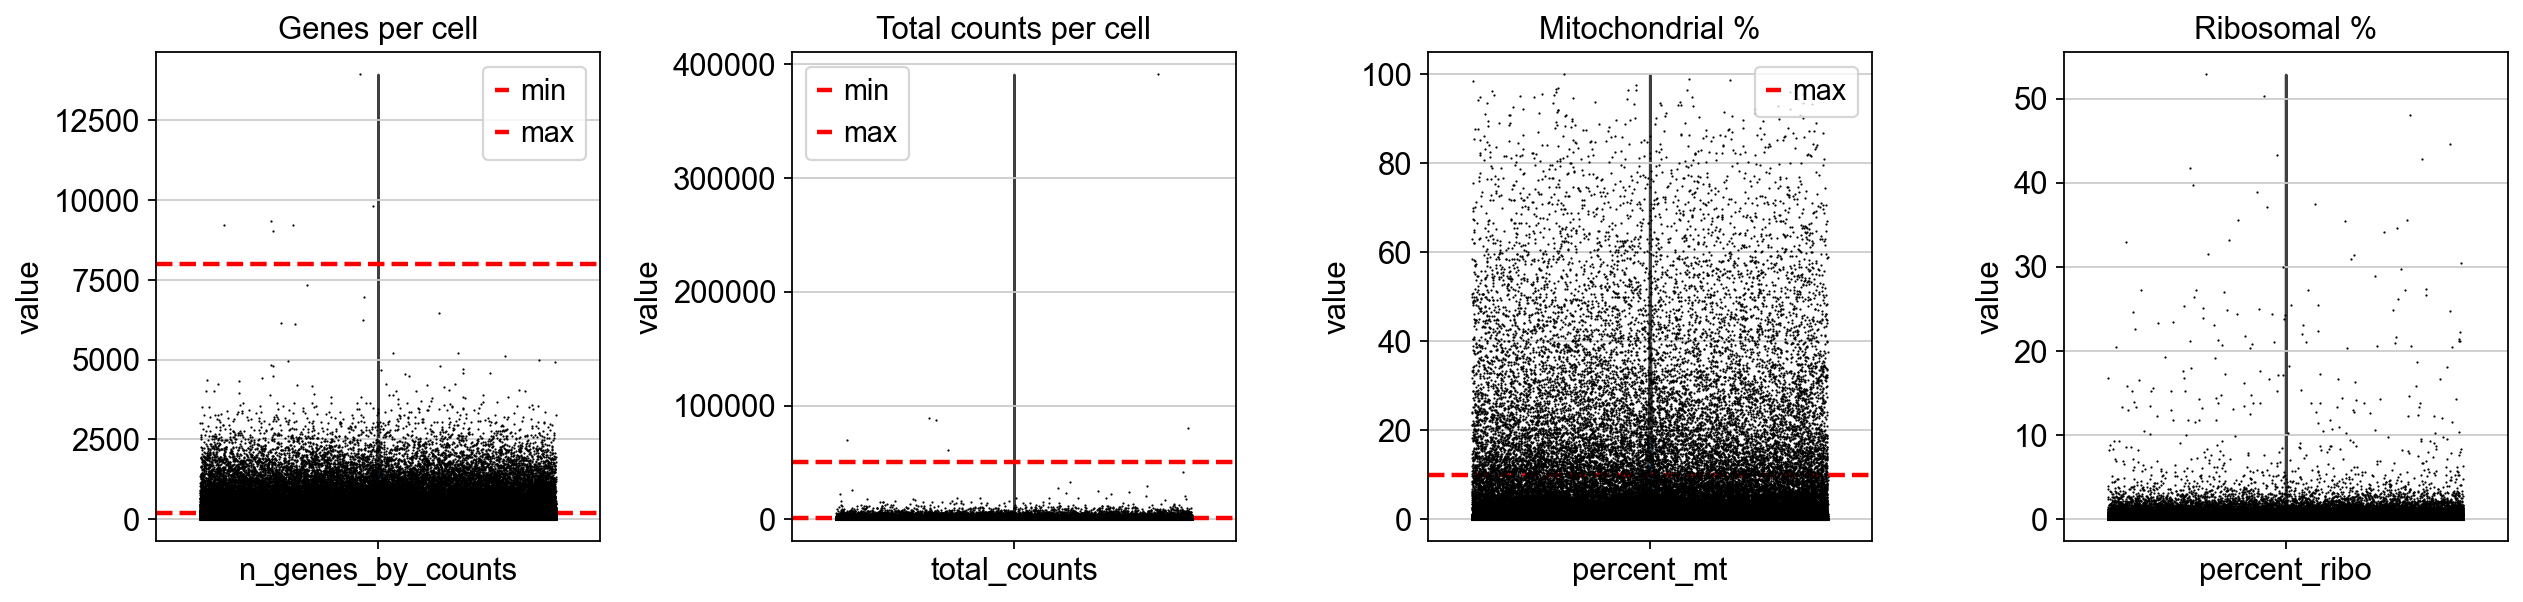

  Saved: plots/qc_scatter_plots.png


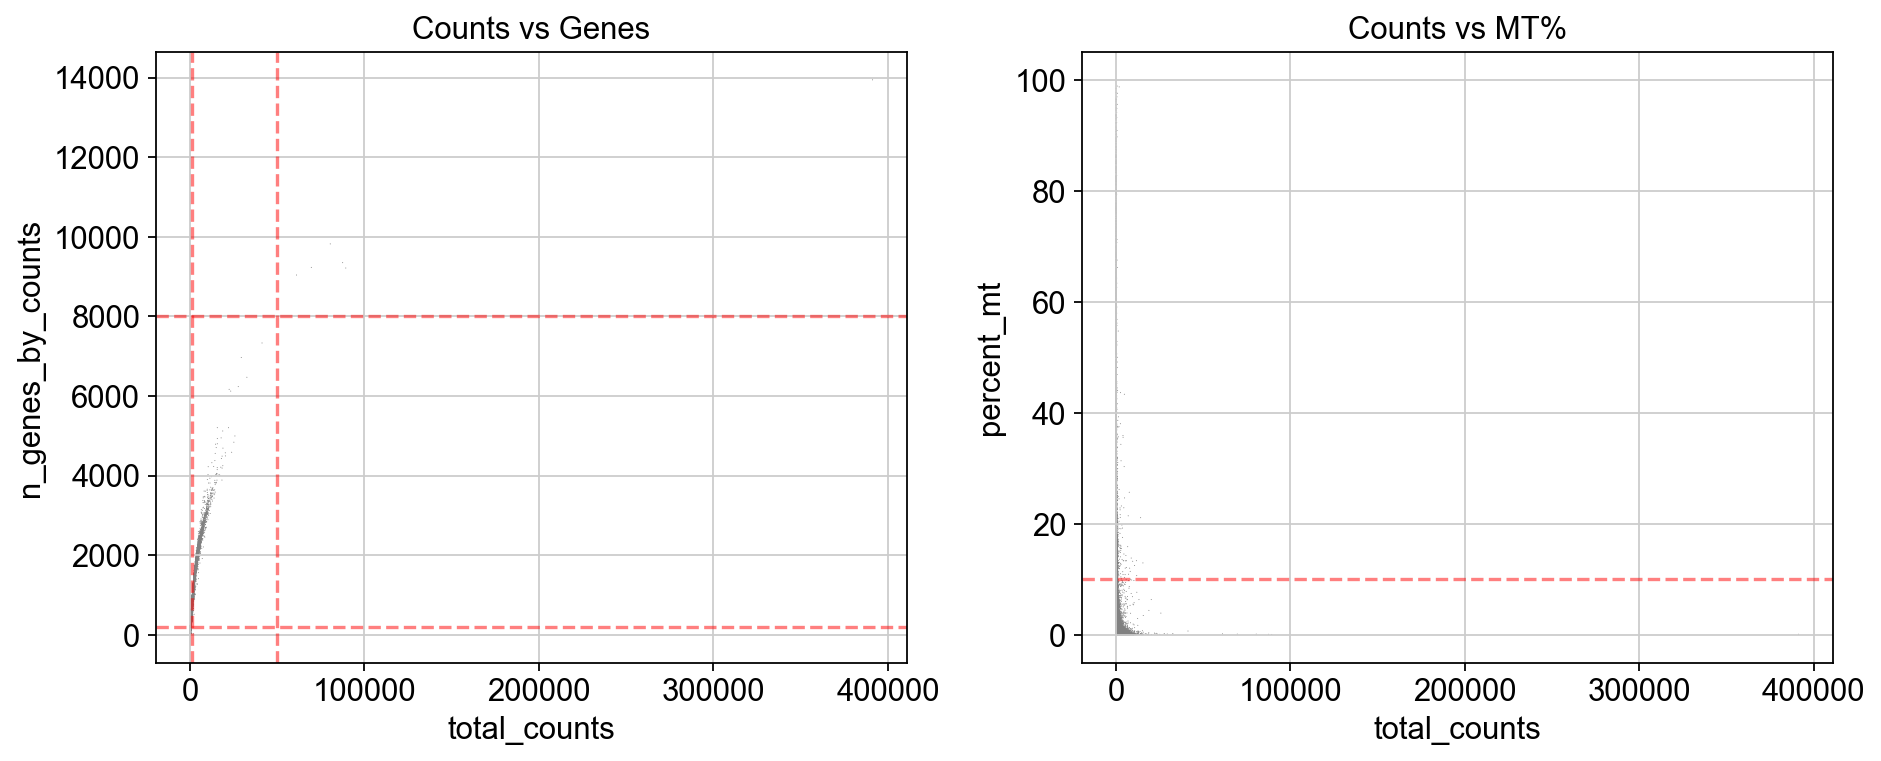


QC Metrics Summary:


,n_genes_by_counts,total_counts,percent_mt,percent_ribo
count,150493.000000,150493.000000,150493.000000,150493.000000
mean,255.936848,468.115035,3.239699,0.190292
std,415.459735,1431.646394,9.760482,0.856435
min,1.000000,1.000000,0.000000,0.000000
25%,40.000000,86.000000,0.000000,0.000000
50%,96.000000,184.000000,0.000000,0.000000
75%,268.000000,443.000000,1.060071,0.166147
max,13942.000000,391198.000000,100.000000,52.879581


In [13]:
def plot_qc_metrics(adata, save_dir=None):
    """Plot QC metric distributions
    
    Args:
        adata: AnnData object with QC metrics
        save_dir: Directory to save plots (optional)
    """
    print("\nPlotting QC metrics...")
    
    # Violin plots
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    sc.pl.violin(adata, 'n_genes_by_counts', jitter=0.4, ax=axes[0], show=False)
    axes[0].axhline(CELL_FILTERS['min_genes'], color='r', linestyle='--', linewidth=2, label='min')
    axes[0].axhline(CELL_FILTERS['max_genes'], color='r', linestyle='--', linewidth=2, label='max')
    axes[0].legend()
    axes[0].set_title('Genes per cell')
    
    sc.pl.violin(adata, 'total_counts', jitter=0.4, ax=axes[1], show=False)
    axes[1].axhline(CELL_FILTERS['min_counts'], color='r', linestyle='--', linewidth=2, label='min')
    axes[1].axhline(CELL_FILTERS['max_counts'], color='r', linestyle='--', linewidth=2, label='max')
    axes[1].legend()
    axes[1].set_title('Total counts per cell')
    
    sc.pl.violin(adata, 'percent_mt', jitter=0.4, ax=axes[2], show=False)
    axes[2].axhline(CELL_FILTERS['max_mt_pct'], color='r', linestyle='--', linewidth=2, label='max')
    axes[2].legend()
    axes[2].set_title('Mitochondrial %')
    
    sc.pl.violin(adata, 'percent_ribo', jitter=0.4, ax=axes[3], show=False)
    if CELL_FILTERS['max_ribo_pct']:
        axes[3].axhline(CELL_FILTERS['max_ribo_pct'], color='r', linestyle='--', linewidth=2, label='max')
        axes[3].legend()
    axes[3].set_title('Ribosomal %')
    
    plt.tight_layout()
    if save_dir:
        fig.savefig(save_dir / 'qc_violin_plots.png', dpi=300, bbox_inches='tight')
        print(f"  Saved: {save_dir}/qc_violin_plots.png")
    plt.show()
    
    # Scatter plots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', ax=axes[0], show=False)
    axes[0].axhline(CELL_FILTERS['min_genes'], color='r', linestyle='--', alpha=0.5)
    axes[0].axhline(CELL_FILTERS['max_genes'], color='r', linestyle='--', alpha=0.5)
    axes[0].axvline(CELL_FILTERS['min_counts'], color='r', linestyle='--', alpha=0.5)
    axes[0].axvline(CELL_FILTERS['max_counts'], color='r', linestyle='--', alpha=0.5)
    axes[0].set_title('Counts vs Genes')
    
    sc.pl.scatter(adata, x='total_counts', y='percent_mt', ax=axes[1], show=False)
    axes[1].axhline(CELL_FILTERS['max_mt_pct'], color='r', linestyle='--', alpha=0.5)
    axes[1].set_title('Counts vs MT%')
    
    plt.tight_layout()
    if save_dir:
        fig.savefig(save_dir / 'qc_scatter_plots.png', dpi=300, bbox_inches='tight')
        print(f"  Saved: {save_dir}/qc_scatter_plots.png")
    plt.show()
    
    # Summary statistics
    print("\nQC Metrics Summary:")
    summary_stats = adata.obs[['n_genes_by_counts', 'total_counts', 'percent_mt', 'percent_ribo']].describe()
    display(summary_stats)

# Plot QC metrics
plot_qc_metrics(adata, save_dir=PLOTS_DIR)

### 💡 Interpreting QC Plots

**What to look for:**

1. **Genes per cell (n_genes_by_counts)**
   - Low values (<200): Likely empty droplets or dead cells
   - Very high values (>8000): Potential doublets
   - Action: Adjust `min_genes` and `max_genes` to capture the main population

2. **Total counts**
   - Should correlate with genes detected
   - Wide spread may indicate batch effects or biological variation
   - Action: Set bounds to exclude extreme outliers

3. **Mitochondrial percentage**
   - High values (>10-20%): Stressed or dying cells
   - Varies by tissue (neurons typically <5%, some tissues naturally higher)
   - Action: Set `max_mt_pct` based on your tissue's characteristics

4. **Scatter plots**
   - Counts vs genes: Should show positive correlation
   - Counts vs MT%: High MT cells often have low counts

**Adjust parameters in Section 2 if needed and re-run from there!**

## 5. Stage 3: Doublet Detection

Identify potential doublets (cells that represent two cells captured together) using Scrublet.

**Key Parameters:**
- `expected_doublet_rate`: Platform-dependent (6-10% typical)
- `manual_threshold`: Score threshold for classification

⚠️ **Critical**: Doublets are detected **per-sample** to account for sample-specific characteristics.

In [14]:
def detect_doublets_improved(adata, expected_doublet_rate=0.10, manual_threshold=0.35,
                            plot_histograms=True, save_dir=None):
    """Detect doublets using Scrublet with per-sample processing
    
    IMPORTANT: Doublets must be detected per-sample to account for
    sample-specific doublet rates and characteristics.
    
    This follows the original pipeline's implementation exactly.
    
    Args:
        adata: AnnData object (should be after basic QC filtering)
        expected_doublet_rate: Expected doublet rate (default 0.10)
        manual_threshold: Manual score threshold (default 0.35)
        plot_histograms: Whether to plot per-sample histograms
        save_dir: Directory to save plots
    
    Returns:
        AnnData object with doublet_score and predicted_doublet columns
    """
    print("\nRunning doublet detection (per-sample)...")
    print(f"  Expected doublet rate: {expected_doublet_rate*100}%")
    print(f"  Manual threshold: {manual_threshold}")
    
    # Initialize arrays to store results for all cells
    all_scores = np.zeros(adata.n_obs)
    all_predictions = np.zeros(adata.n_obs, dtype=bool)
    
    # Get unique samples
    samples = adata.obs['orig.ident'].unique()
    print(f"  Processing {len(samples)} samples separately\n")
    
    # Setup plot if requested
    if plot_histograms and save_dir:
        n_rows = (len(samples) + 3) // 4  # 4 columns
        fig, axes = plt.subplots(n_rows, 4, figsize=(16, 3*n_rows))
        axes = axes.flatten() if len(samples) > 1 else [axes]
    
    # Process each sample separately
    for idx, sample in enumerate(samples):
        print(f"Sample {idx+1}/{len(samples)}: {sample}")
        
        # Get sample mask and indices
        mask = adata.obs['orig.ident'] == sample
        sample_indices = np.where(mask)[0]
        
        # Extract sample data (MUST use .copy()!)
        adata_sample = adata[mask].copy()
        
        # Skip if too few cells
        if adata_sample.n_obs < 100:
            print(f"  ⚠️  Skipping - only {adata_sample.n_obs} cells\n")
            continue
        
        # Initialize Scrublet for this sample
        scrub = scr.Scrublet(
            adata_sample.X,
            expected_doublet_rate=expected_doublet_rate
        )
        
        # Run doublet detection
        doublet_scores, predicted_doublets = scrub.scrub_doublets(
            min_counts=DOUBLET_PARAMS['min_counts'],
            min_cells=DOUBLET_PARAMS['min_cells'],
            min_gene_variability_pctl=DOUBLET_PARAMS['min_gene_variability_pctl'],
            n_prin_comps=DOUBLET_PARAMS['n_prin_comps'],
            verbose=False,
        )
        
        # Get automatic threshold (handle case where it returns None)
        try:
            auto_threshold_result = scrub.call_doublets(threshold=None)
            auto_threshold = auto_threshold_result[1] if auto_threshold_result is not None else None
        except:
            auto_threshold = None
        
        # Use manual threshold if specified, otherwise use automatic (or fallback to 0.35)
        if manual_threshold is not None:
            threshold = manual_threshold
            predicted_doublets = doublet_scores > threshold
        elif auto_threshold is not None:
            threshold = auto_threshold
            predicted_doublets = doublet_scores > threshold
        else:
            # Fallback if automatic threshold fails
            threshold = 0.35
            predicted_doublets = doublet_scores > threshold
            print(f"  ⚠️  Auto threshold failed, using fallback: {threshold}")
        
        # Cap threshold to avoid missing obvious doublets
        if threshold > 0.4:
            print(f"  ⚠️  High threshold {threshold:.2f}, capping at 0.4")
            threshold = 0.4
            predicted_doublets = doublet_scores > threshold
        
        # Store results for this sample's cells
        all_scores[sample_indices] = doublet_scores
        all_predictions[sample_indices] = predicted_doublets
        
        # Calculate statistics
        n_doublets = predicted_doublets.sum()
        pct_doublets = n_doublets / len(doublet_scores) * 100
        
        print(f"  Cells: {len(doublet_scores):,}")
        if auto_threshold is not None:
            print(f"  Threshold: {threshold:.3f} (auto: {auto_threshold:.3f})")
        else:
            print(f"  Threshold: {threshold:.3f} (manual/fallback)")
        print(f"  Doublets: {n_doublets:,} ({pct_doublets:.1f}%)")
        print(f"  Score range: [{doublet_scores.min():.3f}, {doublet_scores.max():.3f}]\n")
        
        # Plot histogram for this sample
        if plot_histograms and save_dir and idx < len(axes):
            ax = axes[idx]
            ax.hist(doublet_scores, bins=50, alpha=0.7, edgecolor='black', color='steelblue')
            ax.axvline(threshold, color='red', linestyle='--', linewidth=2,
                      label=f'Threshold: {threshold:.2f}')
            ax.set_title(f"{sample}\n{n_doublets} doublets ({pct_doublets:.1f}%)", fontsize=10)
            ax.set_xlabel('Doublet Score', fontsize=9)
            ax.set_ylabel('Frequency', fontsize=9)
            ax.legend(fontsize=8)
            ax.grid(alpha=0.3)
    
    # Hide unused subplots
    if plot_histograms and save_dir:
        for idx in range(len(samples), len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.savefig(save_dir / 'doublet_score_histograms.png', dpi=300, bbox_inches='tight')
        print(f"✓ Saved: {save_dir}/doublet_score_histograms.png")
        plt.show()
        plt.close()
    
    # Add results to adata
    adata.obs['doublet_score'] = all_scores
    adata.obs['predicted_doublet'] = all_predictions
    
    # Overall summary
    total_doublets = all_predictions.sum()
    overall_rate = total_doublets / len(all_predictions) * 100
    
    print("="*60)
    print(f"OVERALL SUMMARY")
    print("="*60)
    print(f"Total cells processed: {len(all_predictions):,}")
    print(f"Total doublets detected: {total_doublets:,} ({overall_rate:.1f}%)")
    print("="*60)
    
    return adata


PREPARING CELLS FOR DOUBLET DETECTION
Applying initial QC filters for doublet detection...
Starting with 150,493 cells

Cells passing initial QC: 44,919
Cells filtered out: 105,574


Running doublet detection (per-sample)...
  Expected doublet rate: 10.0%
  Manual threshold: 0.25
  Processing 16 samples separately

Sample 1/16: D25-2675
  Cells: 5,629
  Threshold: 0.250 (manual/fallback)
  Doublets: 0 (0.0%)
  Score range: [0.000, 0.000]

Sample 2/16: D25-2676
  Cells: 1,903
  Threshold: 0.250 (manual/fallback)
  Doublets: 0 (0.0%)
  Score range: [0.001, 0.001]

Sample 3/16: D25-2677
  Cells: 1,336
  Threshold: 0.250 (manual/fallback)
  Doublets: 0 (0.0%)
  Score range: [0.001, 0.001]

Sample 4/16: D25-2678
  Cells: 2,510
  Threshold: 0.250 (manual/fallback)
  Doublets: 0 (0.0%)
  Score range: [0.001, 0.001]

Sample 5/16: D25-2679
  Cells: 4,019
  Threshold: 0.250 (manual/fallback)
  Doublets: 0 (0.0%)
  Score range: [0.001, 0.001]

Sample 6/16: D25-2680
  Cells: 1,741
  Threshold: 0.

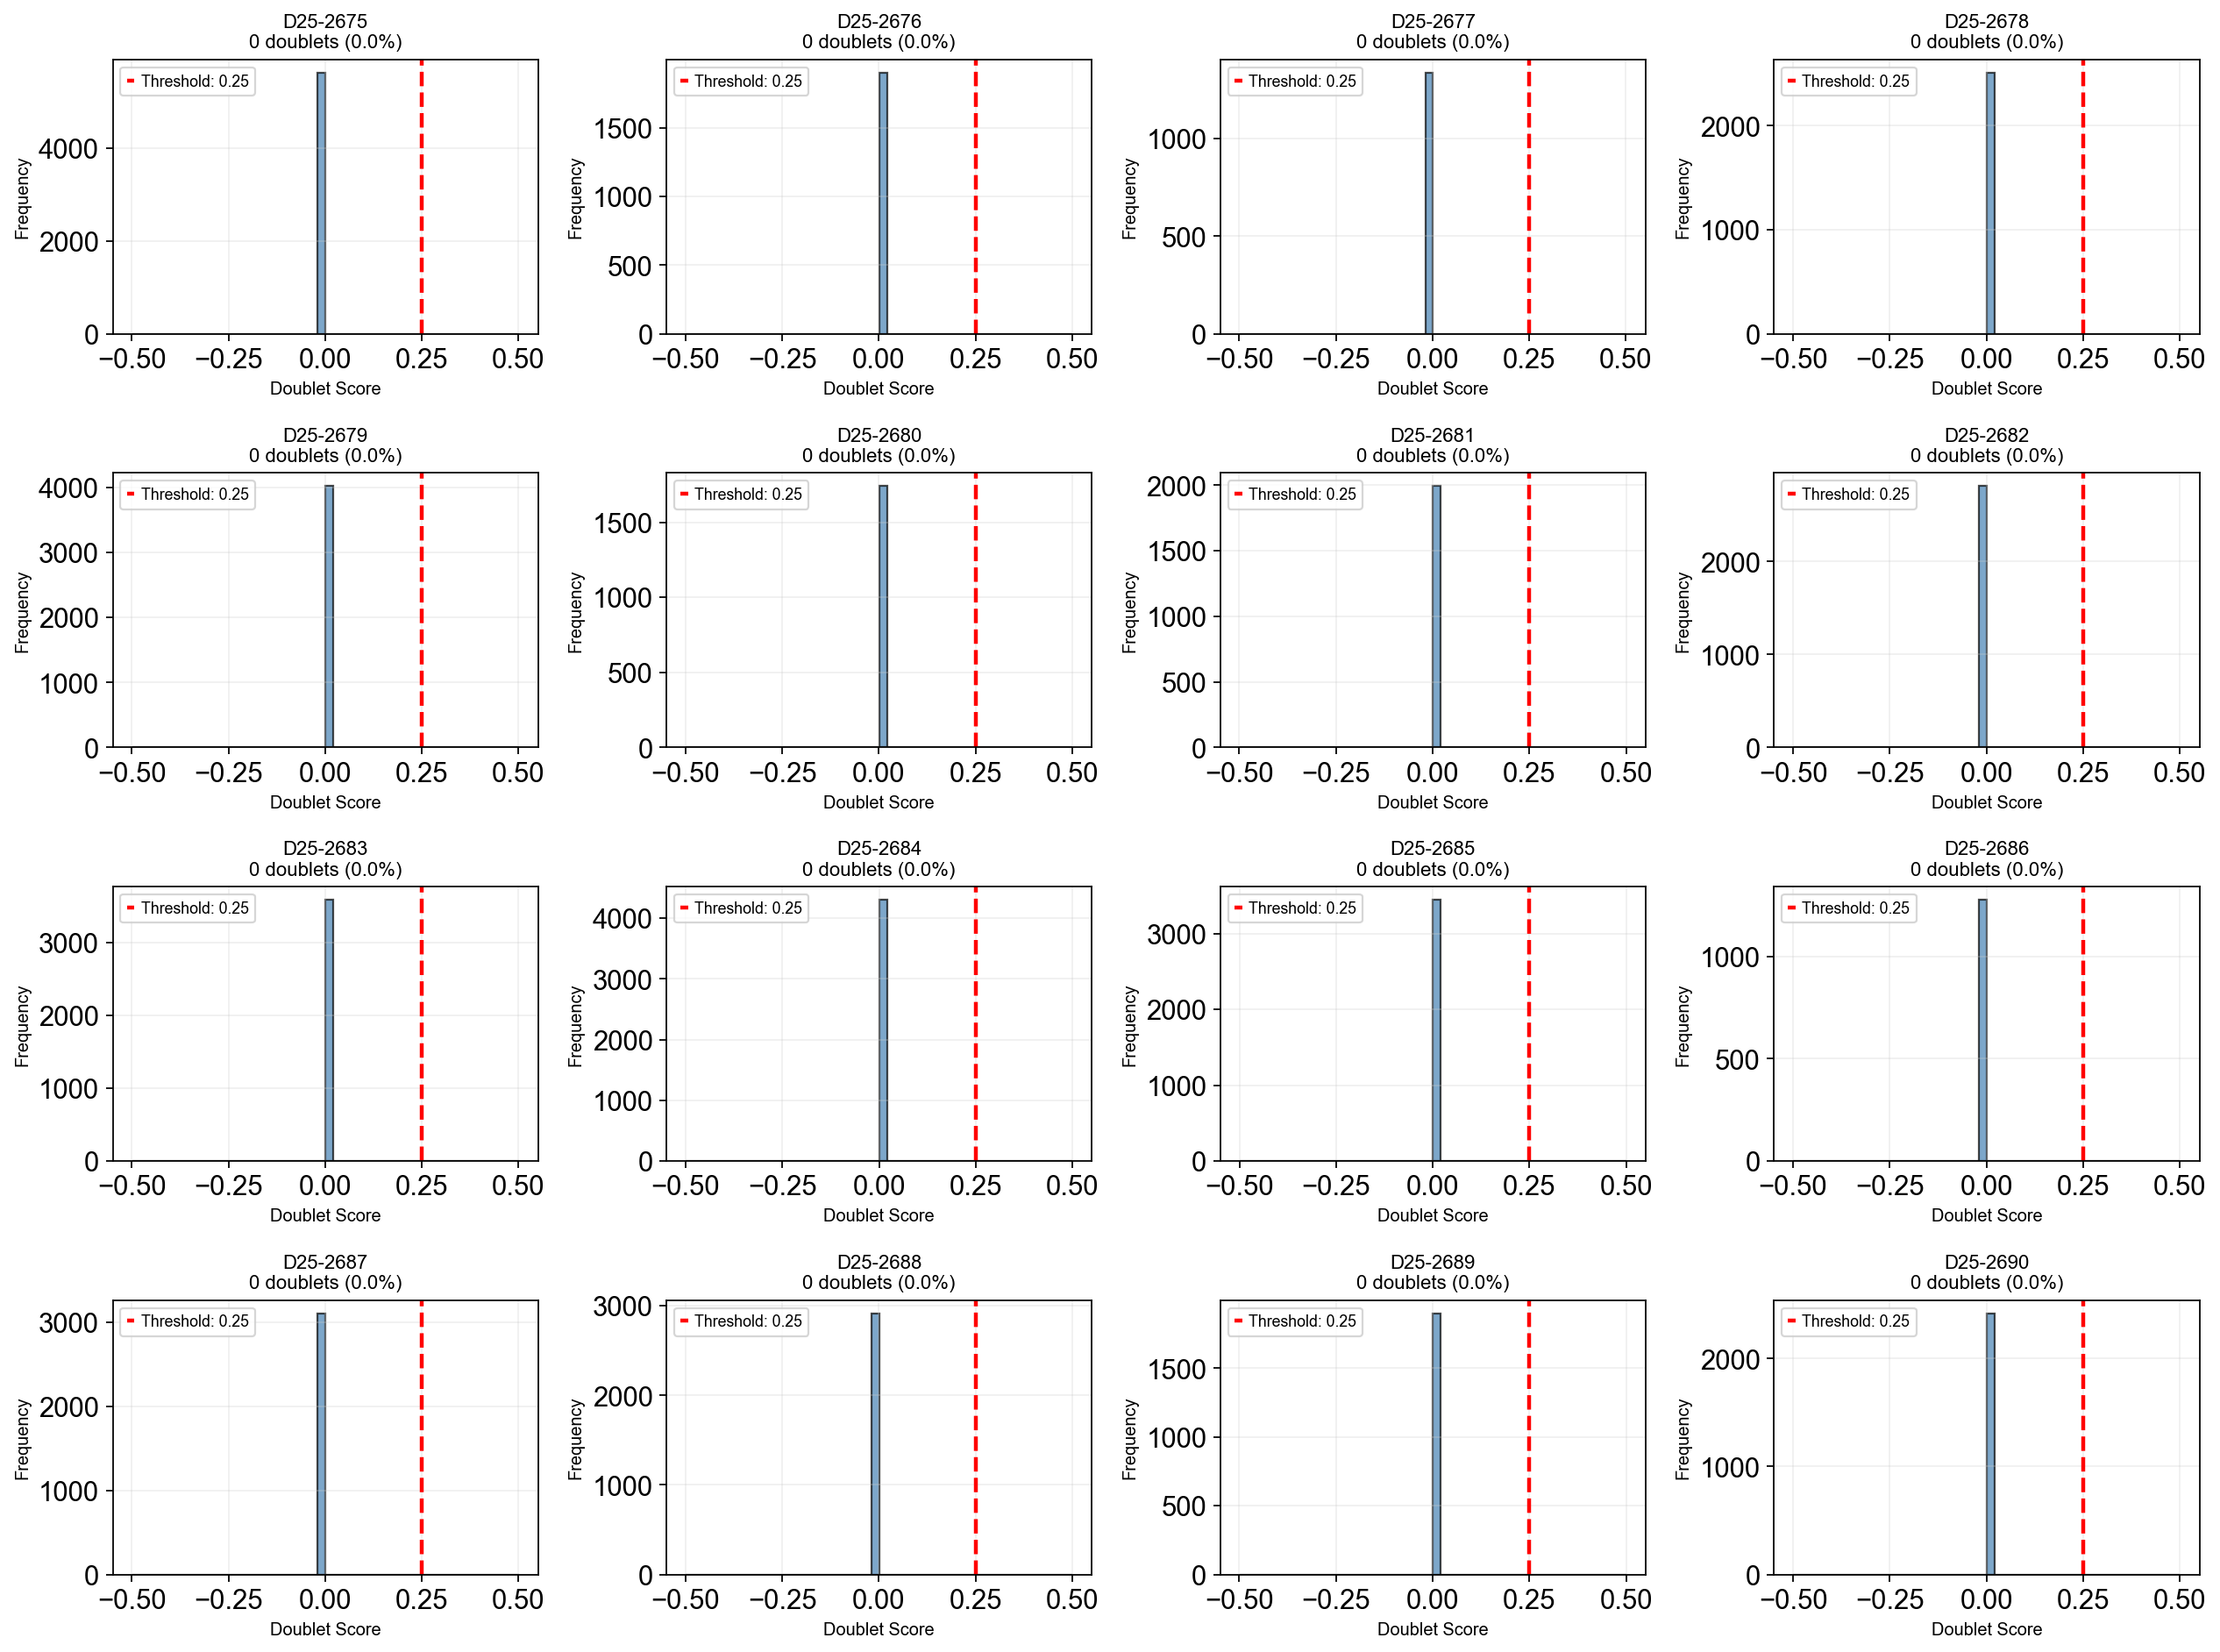

OVERALL SUMMARY
Total cells processed: 44,919
Total doublets detected: 0 (0.0%)

Transferring doublet annotations to full dataset...

✓ Doublet detection complete!


In [15]:
# Apply basic QC filters BEFORE doublet detection
# This is critical - we filter cells first to improve doublet detection
print("\n" + "="*60)
print("PREPARING CELLS FOR DOUBLET DETECTION")
print("="*60)
print("Applying initial QC filters for doublet detection...")
print(f"Starting with {adata.n_obs:,} cells\n")

adata_for_doublets = adata[
    (adata.obs.n_genes_by_counts >= CELL_FILTERS['min_genes']) &
    (adata.obs.n_genes_by_counts <= CELL_FILTERS['max_genes']) &
    (adata.obs.percent_mt <= CELL_FILTERS['max_mt_pct'])
].copy()

print(f"Cells passing initial QC: {adata_for_doublets.n_obs:,}")
print(f"Cells filtered out: {adata.n_obs - adata_for_doublets.n_obs:,}\n")

# Detect doublets on QC-filtered cells
adata_for_doublets = detect_doublets_improved(
    adata_for_doublets,
    expected_doublet_rate=DOUBLET_PARAMS['expected_doublet_rate'],
    manual_threshold=DOUBLET_PARAMS['manual_threshold'],
    plot_histograms=True,
    save_dir=PLOTS_DIR,
)

# Transfer doublet annotations back to original adata
print("\nTransferring doublet annotations to full dataset...")
adata.obs['doublet_score'] = 0.0
adata.obs['predicted_doublet'] = False
adata.obs.loc[adata_for_doublets.obs.index, 'doublet_score'] = adata_for_doublets.obs['doublet_score']
adata.obs.loc[adata_for_doublets.obs.index, 'predicted_doublet'] = adata_for_doublets.obs['predicted_doublet']

print("\n✓ Doublet detection complete!")

### 💡 Tuning Doublet Detection

**Key considerations:**

1. **Expected doublet rate**
   - 10x Chromium v2: ~4-6%
   - 10x Chromium v3: ~6-8%
   - High-throughput: ~8-10%
   - Check your platform specifications

2. **Manual threshold**
   - Default: 0.35
   - Lower (0.25-0.30): More stringent, removes more cells
   - Higher (0.40-0.50): More permissive, retains more cells
   - Examine histograms: clear separation = good, overlap = difficult

3. **Per-sample processing**
   - ⚠️ **Critical**: Each sample has unique characteristics
   - Different cell loading densities → different doublet rates
   - Different cell types → different score distributions
   - Always process samples separately!

4. **What to check after clustering:**
   - Doublets should appear as intermediate clusters on UMAP
   - Check if "doublet clusters" express markers from 2+ cell types
   - If residual doublets remain, lower the threshold and re-run

## 6. Stage 4: Cell & Gene Filtering

Apply QC filters to remove low-quality cells and rarely-expressed genes.

**Filters Applied (in order):**
1. Remove cells with too few genes (min_genes)
2. Remove genes expressed in too few cells (min_cells)
3. Remove cells with too many genes (max_genes)
4. Remove cells with high MT% (max_mt_pct)
5. Remove cells outside count ranges (min/max_counts)
6. Remove cells with high ribosomal% (if set)
7. **Remove doublets LAST**

⚠️ **Important**: Doublets are removed LAST after all other QC filters.

In [16]:
def filter_cells_and_genes(adata, min_genes=200, max_genes=8000, max_mt_pct=10,
                          min_counts=1000, max_counts=50000, max_ribo_pct=None):
    """Apply QC filtering in the correct order
    
    IMPORTANT: Filtering order matters!
    This follows the original pipeline's order exactly:
    1. min_genes → 2. min_cells → 3. max_genes → 4. max_mt_pct →
    5. count filters → 6. ribo% → 7. doublets LAST
    
    Args:
        adata: AnnData object
        min_genes: Minimum genes per cell
        max_genes: Maximum genes per cell
        max_mt_pct: Maximum mitochondrial percentage
        min_counts: Minimum total counts per cell
        max_counts: Maximum total counts per cell
        max_ribo_pct: Maximum ribosomal percentage (optional)
    
    Returns:
        Filtered AnnData object
    """
    print("\n" + "="*60)
    print("APPLYING QC FILTERS")
    print("="*60)
    print(f"Starting: {adata.n_obs:,} cells × {adata.n_vars:,} genes\n")
    
    # 1. Filter cells by minimum genes
    n_before = adata.n_obs
    sc.pp.filter_cells(adata, min_genes=min_genes)
    print(f"[1/7] After min_genes ({min_genes}) filter:")
    print(f"      {adata.n_obs:,} cells ({n_before - adata.n_obs:,} removed)\n")
    
    # 2. Filter genes by minimum cells expressing
    n_genes_before = adata.n_vars
    sc.pp.filter_genes(adata, min_cells=GENE_FILTERS['min_cells'])
    print(f"[2/7] After min_cells ({GENE_FILTERS['min_cells']}) filter:")
    print(f"      {adata.n_vars:,} genes ({n_genes_before - adata.n_vars:,} removed)\n")
    
    # 3. Filter cells by maximum genes
    n_before = adata.n_obs
    adata = adata[adata.obs.n_genes_by_counts < max_genes].copy()
    print(f"[3/7] After max_genes ({max_genes}) filter:")
    print(f"      {adata.n_obs:,} cells ({n_before - adata.n_obs:,} removed)\n")
    
    # 4. Filter cells by MT percentage
    n_before = adata.n_obs
    adata = adata[adata.obs.percent_mt < max_mt_pct].copy()
    print(f"[4/7] After max_mt_pct ({max_mt_pct}%) filter:")
    print(f"      {adata.n_obs:,} cells ({n_before - adata.n_obs:,} removed)\n")
    
    # 5a. Optional: Filter by minimum counts
    if min_counts is not None:
        n_before = adata.n_obs
        adata = adata[adata.obs.total_counts >= min_counts].copy()
        print(f"[5a/7] After min_counts ({min_counts}) filter:")
        print(f"       {adata.n_obs:,} cells ({n_before - adata.n_obs:,} removed)\n")
    else:
        print(f"[5a/7] min_counts filter: SKIPPED (not set)\n")
    
    # 5b. Optional: Filter by maximum counts
    if max_counts is not None:
        n_before = adata.n_obs
        adata = adata[adata.obs.total_counts <= max_counts].copy()
        print(f"[5b/7] After max_counts ({max_counts}) filter:")
        print(f"       {adata.n_obs:,} cells ({n_before - adata.n_obs:,} removed)\n")
    else:
        print(f"[5b/7] max_counts filter: SKIPPED (not set)\n")
    
    # 6. Optional: Filter by ribosomal percentage
    if max_ribo_pct is not None:
        n_before = adata.n_obs
        adata = adata[adata.obs.percent_ribo < max_ribo_pct].copy()
        print(f"[6/7] After max_ribo_pct ({max_ribo_pct}%) filter:")
        print(f"      {adata.n_obs:,} cells ({n_before - adata.n_obs:,} removed)\n")
    else:
        print(f"[6/7] max_ribo_pct filter: SKIPPED (not set)\n")
    
    # 7. Remove doublets LAST (most important!)
    n_before = adata.n_obs
    n_doublets = adata.obs.predicted_doublet.sum()
    adata = adata[~adata.obs.predicted_doublet].copy()
    print(f"[7/7] After doublet removal:")
    print(f"      {adata.n_obs:,} cells ({n_doublets:,} doublets removed)\n")
    
    print("="*60)
    print(f"FINAL: {adata.n_obs:,} cells × {adata.n_vars:,} genes")
    print("="*60)
    
    return adata

# Apply filters
adata = filter_cells_and_genes(
    adata,
    min_genes=CELL_FILTERS['min_genes'],
    max_genes=CELL_FILTERS['max_genes'],
    max_mt_pct=CELL_FILTERS['max_mt_pct'],
    min_counts=CELL_FILTERS['min_counts'],
    max_counts=CELL_FILTERS['max_counts'],
    max_ribo_pct=CELL_FILTERS['max_ribo_pct'],
)


APPLYING QC FILTERS
Starting: 150,493 cells × 32,285 genes

filtered out 103899 cells that have less than 200 genes expressed
[1/7] After min_genes (200) filter:
      46,594 cells (103,899 removed)

filtered out 12677 genes that are detected in less than 10 cells
[2/7] After min_cells (10) filter:
      19,608 genes (12,677 removed)

[3/7] After max_genes (8000) filter:
      46,588 cells (6 removed)

[4/7] After max_mt_pct (10%) filter:
      44,910 cells (1,678 removed)

[5a/7] After min_counts (1000) filter:
       16,188 cells (28,722 removed)

[5b/7] After max_counts (50000) filter:
       16,188 cells (0 removed)

[6/7] max_ribo_pct filter: SKIPPED (not set)

[7/7] After doublet removal:
      16,188 cells (0 doublets removed)

FINAL: 16,188 cells × 19,608 genes



Generating filtered data summary plots...


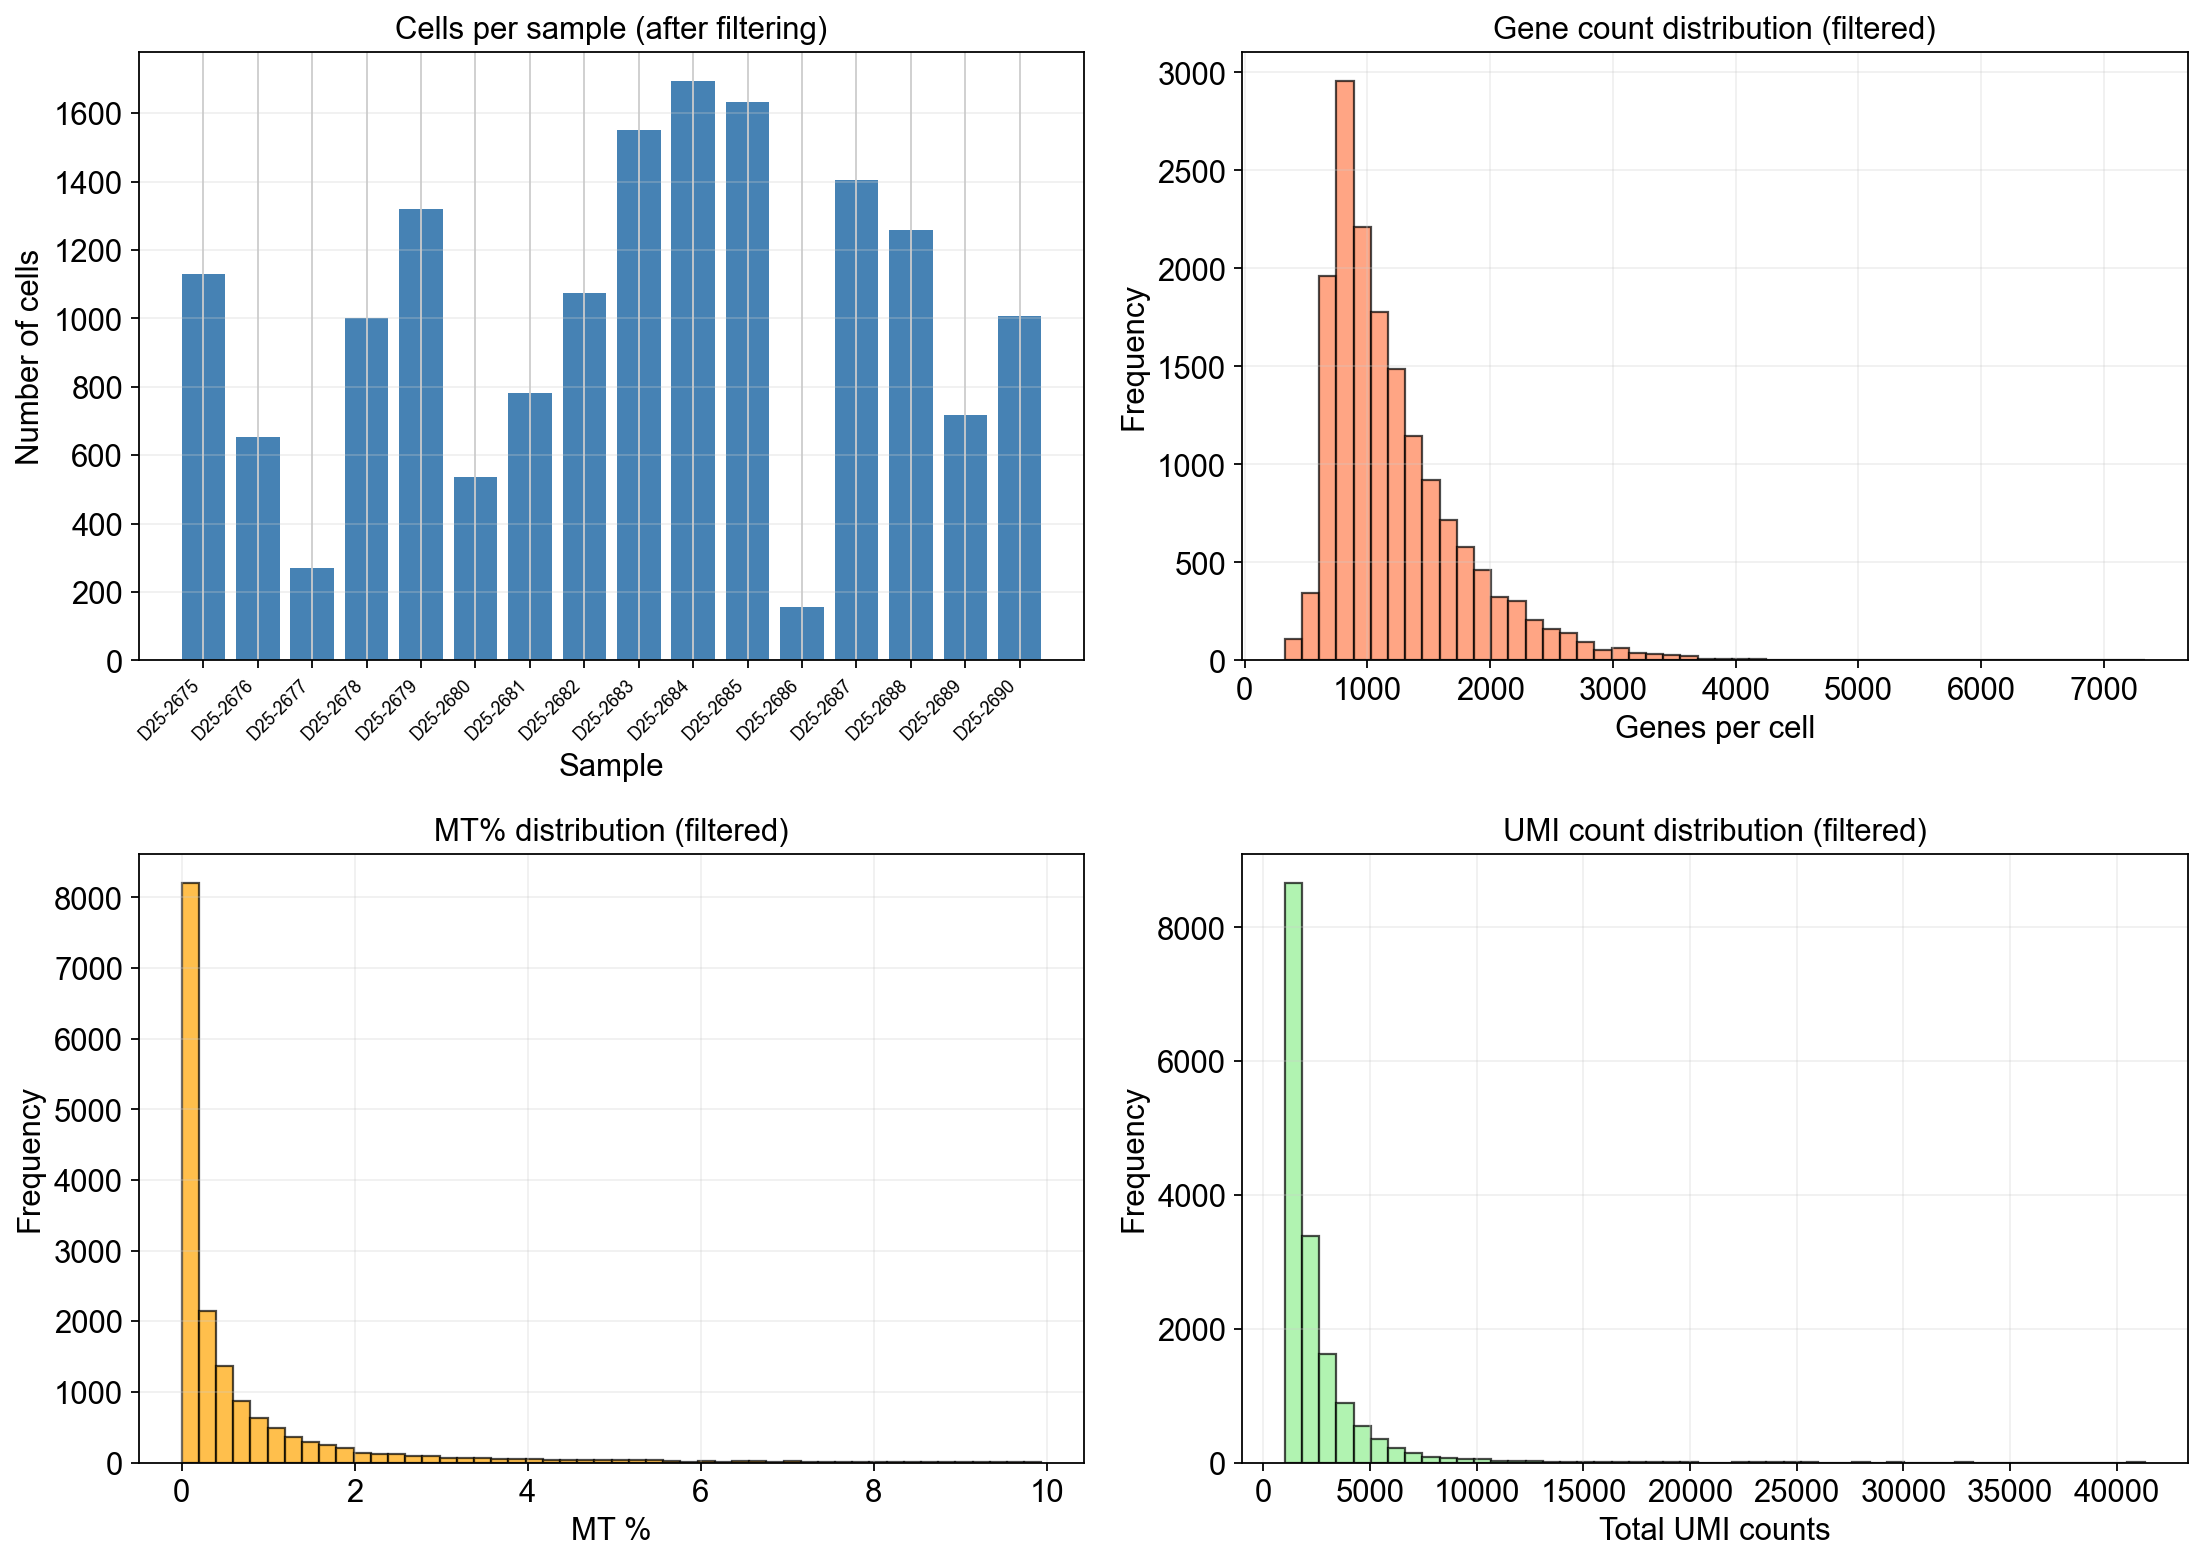


✓ Filtered data summary saved to plots/filtered_data_summary.png


In [17]:
# Visualize filtered data statistics
print("\nGenerating filtered data summary plots...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Cells per sample
sample_counts = adata.obs['orig.ident'].value_counts().sort_index()
axes[0, 0].bar(range(len(sample_counts)), sample_counts.values, color='steelblue')
axes[0, 0].set_xticks(range(len(sample_counts)))
axes[0, 0].set_xticklabels(sample_counts.index, rotation=45, ha='right', fontsize=8)
axes[0, 0].set_xlabel('Sample')
axes[0, 0].set_ylabel('Number of cells')
axes[0, 0].set_title('Cells per sample (after filtering)')
axes[0, 0].grid(axis='y', alpha=0.3)

# Gene count distribution
axes[0, 1].hist(adata.obs['n_genes_by_counts'], bins=50, alpha=0.7, color='coral', edgecolor='black')
axes[0, 1].set_xlabel('Genes per cell')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Gene count distribution (filtered)')
axes[0, 1].grid(alpha=0.3)

# MT% distribution
axes[1, 0].hist(adata.obs['percent_mt'], bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1, 0].set_xlabel('MT %')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('MT% distribution (filtered)')
axes[1, 0].grid(alpha=0.3)

# UMI count distribution
axes[1, 1].hist(adata.obs['total_counts'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 1].set_xlabel('Total UMI counts')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('UMI count distribution (filtered)')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'filtered_data_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Filtered data summary saved to {PLOTS_DIR}/filtered_data_summary.png")

### 🎛️ Parameter Tuning Guide: QC Results

Review the QC plots above. What did you observe?

---

#### **📊 Genes per cell (n_genes_by_counts)**

<details>
<summary><b>Two distinct populations:</b> One low (&lt;500) and one higher (2000-5000)</summary>

**Diagnosis:** Low population likely represents empty droplets or dead cells

**Action:**
```python
# Scroll back to Parameter Configuration (Cell 9) and update:
CELL_FILTERS['min_genes'] = 300  # Increase threshold to exclude low population
```

**Then:** Re-run from Stage 2 (Cell 18)

**Specific thresholds:**
- Conservative (high quality): `min_genes = 500`, `max_genes = 6000`
- Standard (balanced): `min_genes = 200`, `max_genes = 8000`
- Permissive: `min_genes = 100`, `max_genes = 10000`
</details>

<details>
<summary><b>Long tail extending to &gt;10,000 genes</b></summary>

**Diagnosis:** High gene count cells are likely doublets

**Action:**
```python
CELL_FILTERS['max_genes'] = 6000  # More stringent upper bound
```

**Then:** Re-run from Stage 2
</details>

<details>
<summary><b>Main population centered around 3000-4000 with tight distribution</b></summary>

**Diagnosis:** ✅ High quality data

**Action:** Current parameters OK, proceed to Stage 3
</details>

<details>
<summary><b>Very wide distribution (500-8000) without clear peaks</b></summary>

**Diagnosis:** Could be biological (different cell types) or technical (batch effects)

**Actions to investigate:**
1. Check if this matches expected cell type diversity
2. Color UMAP by sample after clustering to check for batch effects
3. If technical issue, consider batch correction

**For now:** Proceed with current parameters, validate after clustering
</details>

---

#### **📊 Mitochondrial % (percent_mt)**

<details>
<summary><b>Main population at 2-5% with tail extending to 20%+</b></summary>

**Diagnosis:** Tail represents stressed/dying cells

**Action:**
```python
CELL_FILTERS['max_mt_pct'] = 10  # Standard cutoff
# Or for neurons:
CELL_FILTERS['max_mt_pct'] = 5   # More stringent
```

**Tissue-specific recommendations:**
- Neurons (cortex, hippocampus): `max_mt_pct = 5`
- Mixed brain (includes glia): `max_mt_pct = 10`
- Peripheral tissues: `max_mt_pct = 15`
- Stressed/diseased tissue: `max_mt_pct = 20` (use cautiously)

**Then:** Re-run from Stage 2
</details>

<details>
<summary><b>Bimodal distribution:</b> One peak at ~5%, another at ~15%</summary>

**Diagnosis:** Could be biological (certain cell types) or technical (degradation)

**Investigation needed:**
1. After clustering, check which cell types have high MT%
2. If specific cell types (e.g., metabolically active cells): Biological, keep permissive
3. If random across cell types: Technical issue

**Decision:**
- If biological: `max_mt_pct = 15-20`
- If technical: `max_mt_pct = 8`
</details>

<details>
<summary><b>Main population already &lt;5%</b></summary>

**Diagnosis:** ✅ Excellent quality cells

**Action:**
```python
CELL_FILTERS['max_mt_pct'] = 5  # Very high quality threshold
```

**Reason:** You can be more stringent with high-quality data
</details>

---

#### **📊 Total Counts**

<details>
<summary><b>Long left tail (&lt;1000 counts)</b></summary>

**Diagnosis:** Low count cells have insufficient information

**Action:**
```python
CELL_FILTERS['min_counts'] = 1500  # Increase minimum
# Or more stringent:
CELL_FILTERS['min_counts'] = 2000
```

**Then:** Re-run from Stage 2
</details>

<details>
<summary><b>Outliers with &gt;100,000 counts</b></summary>

**Diagnosis:** Extremely high counts may be doublets or technical artifacts

**Action:**
```python
CELL_FILTERS['max_counts'] = 60000  # Cap at reasonable level
```

**Then:** Re-run from Stage 2
</details>

<details>
<summary><b>Tight distribution around 10,000-30,000</b></summary>

**Diagnosis:** ✅ Ideal - consistent sequencing depth

**Action:** Current parameters OK, proceed
</details>

---

#### **📊 Scatter Plots: Counts vs Genes**

<details>
<summary><b>Linear relationship but some points way above the line</b></summary>

**Diagnosis:** These are likely doublets

**Action:** 
- Proceed to doublet detection (Stage 3)
- After doublet detection, verify these points are flagged as doublets
- If not caught, lower doublet threshold
</details>

<details>
<summary><b>Two distinct linear relationships</b></summary>

**Diagnosis:** Two populations with different RNA content

**Could be:**
- Biological (e.g., neurons vs glia - different cell sizes)
- Technical (batch effect)

**Action:** Don't over-filter - investigate after clustering and UMAP
</details>

---

#### **📊 Scatter Plots: Counts vs MT%**

<details>
<summary><b>High MT% cells clustered at LOW counts</b></summary>

**Diagnosis:** Classic signature of dying cells (lost cytoplasmic RNA, retained MT RNA)

**Action:**
```python
CELL_FILTERS['max_mt_pct'] = 10  # Exclude dying cells
```

**Then:** Re-run from Stage 2
</details>

<details>
<summary><b>High MT% cells have NORMAL counts</b></summary>

**Diagnosis:** May be biologically relevant (highly metabolic cell types)

**Examples:** Cardiomyocytes, muscle cells, certain neurons

**Action:** 
- Keep more permissive `max_mt_pct`
- Validate after clustering - check which cell types have high MT%
</details>

<details>
<summary><b>No correlation between counts and MT%</b></summary>

**Diagnosis:** ✅ No obvious cell stress pattern

**Action:** Proceed with standard `max_mt_pct = 10`
</details>

---

#### **💡 Expected Cell Retention**

After filtering, typical retention rates:
- **Excellent quality:** 70-85% of cells pass filters
- **Good quality:** 50-70% of cells pass filters
- **Problematic:** <50% of cells pass → investigate data quality

**If you retain <40% of cells:**
1. Check QC plots for anomalies
2. Verify CellBender ran correctly
3. Consider more permissive thresholds
4. Check for sample-specific issues

In [18]:
# QC Metrics Assessment
print("\n" + "="*60)
print("QC METRICS ASSESSMENT")
print("="*60)

median_genes = adata.obs['n_genes_by_counts'].median()
median_mt = adata.obs['percent_mt'].median()

print(f"Median genes/cell: {median_genes:.0f}")
if median_genes < 2000:
    print("⚠️  LOW: Check sequencing depth")
elif median_genes > 5000:
    print("✅ EXCELLENT: High quality")
else:
    print("✅ GOOD: Normal range")

print(f"\nMedian MT%: {median_mt:.2f}%")
if median_mt > 10:
    print("⚠️  HIGH: Consider max_mt_pct = 8")
elif median_mt < 5:
    print("✅ EXCELLENT: Low stress")
else:
    print("✅ GOOD: Acceptable")

print("\n💡 NEXT STEPS:")
if median_genes < 2000 or median_mt > 10:
    print("   • Adjust parameters and re-run Stage 2")
else:
    print("   • Proceed to Stage 3")



QC METRICS ASSESSMENT
Median genes/cell: 1064
⚠️  LOW: Check sequencing depth

Median MT%: 0.19%
✅ EXCELLENT: Low stress

💡 NEXT STEPS:
   • Adjust parameters and re-run Stage 2


### 🎛️ Parameter Tuning Guide: Doublet Detection

Review the per-sample histograms above. What did you observe?

---

#### **📊 Doublet Score Distributions**

<details>
<summary><b>Clear separation:</b> Peak at 0.1-0.2, gap, then doublets at 0.4-0.6</summary>

**Diagnosis:** ✅ Ideal - clear separation allows confident calling

**Action:** Current `manual_threshold = 0.35` is perfect, proceed to Stage 4
</details>

<details>
<summary><b>Bimodal with overlap:</b> Singlet peak at ~0.15, doublet peak at ~0.35, overlapping at 0.25-0.3</summary>

**Diagnosis:** Difficult to separate cleanly

**Decision depends on your analysis goals:**

**Conservative approach (fewer false positives):**
```python
DOUBLET_PARAMS['manual_threshold'] = 0.25  # More stringent
```
- Removes more cells, some singlets may be lost
- **Use when:** Doing differential expression, need high confidence

**Permissive approach (fewer false negatives):**
```python
DOUBLET_PARAMS['manual_threshold'] = 0.40  # More lenient
```
- Keeps more cells, some doublets may remain
- **Use when:** Exploratory analysis, can filter doublets later

**Then:** Re-run from Stage 3 (Cell 23)
</details>

<details>
<summary><b>Most cells have low scores (&lt;0.3) with few outliers</b></summary>

**Diagnosis:** ✅ Clear doublets are easily identified

**Action:**
```python
DOUBLET_PARAMS['manual_threshold'] = 0.30  # Slightly lower is fine
```

**Reason:** Outliers are obvious doublets; exact threshold doesn't matter much
</details>

<details>
<summary><b>Continuously distributed (no clear peaks):</b> Smooth distribution from 0.0 to 0.6</summary>

**Diagnosis:** ⚠️ Difficult to separate singlets from doublets

**Possible causes:**
- Very homogeneous cell population (hard for Scrublet to detect doublets)
- Poor sample quality
- Too few cells in sample (<500)

**Actions:**
1. Use expected rate-based threshold:
```python
# If expected_doublet_rate = 0.10:
DOUBLET_PARAMS['manual_threshold'] = 0.15  # expected + 0.05
```

2. After clustering, visually inspect UMAP for doublet clusters
3. Validate with marker genes (doublets express markers from 2+ cell types)

**Then:** Re-run from Stage 3, then validate carefully after clustering
</details>

---

#### **📊 Per-Sample Doublet Rates**

<details>
<summary><b>Rates vary widely across samples</b> (e.g., Sample A: 5%, Sample B: 15%, Sample C: 8%)</summary>

**Diagnosis:** Sample-specific variation

**Investigation needed:**
1. Check if Sample B had higher cell loading concentration → Expected variation
2. Check cell counts per sample → High-count samples often have higher doublet rates
3. Verify sample quality metrics

**Decision tree:**
```
Sample doublet rate > 15%?
├─ Yes: Was this sample loaded at higher concentration?
│  ├─ Yes: OK, this is expected
│  └─ No: Consider:
│      • Stricter threshold (0.25-0.30) for this sample
│      • Excluding sample if quality is poor
│      • Checking for technical issues
└─ No: Proceed with current settings
```

**If action needed:**
```python
# More stringent globally:
DOUBLET_PARAMS['manual_threshold'] = 0.30
```
</details>

<details>
<summary><b>All samples have very low doublet rates (&lt;3%)</b></summary>

**Diagnosis:** ⚠️ Detection may be too permissive

**Typical 10x rates:** 6-10% for standard protocols - <3% is suspicious

**Action:**
```python
DOUBLET_PARAMS['manual_threshold'] = 0.25  # Lower threshold
```

**Validation:** After re-running, check UMAP for doublet clusters

**Then:** Re-run from Stage 3
</details>

<details>
<summary><b>All samples have very high doublet rates (&gt;20%)</b></summary>

**Diagnosis:** ⚠️ Detection may be too stringent OR sample quality is poor

**Actions:**

1. **Try raising threshold:**
```python
DOUBLET_PARAMS['manual_threshold'] = 0.40  # More permissive
```

2. **Check expected doublet rate:**
```python
DOUBLET_PARAMS['expected_doublet_rate'] = 0.10  # Verify this matches your platform
```

3. **If still high:** Consider sample quality issues, review QC metrics

**Then:** Re-run from Stage 3
</details>

<details>
<summary><b>Doublet rates 6-10% per sample</b></summary>

**Diagnosis:** ✅ Normal for 10x Chromium

**Action:** Proceed to Stage 4, current settings are good
</details>

---

#### **📊 Platform-Specific Expected Rates**

```python
# 10x Chromium v2 (older platform):
DOUBLET_PARAMS['expected_doublet_rate'] = 0.06
DOUBLET_PARAMS['manual_threshold'] = 0.35

# 10x Chromium v3 (standard):
DOUBLET_PARAMS['expected_doublet_rate'] = 0.08
DOUBLET_PARAMS['manual_threshold'] = 0.35

# 10x Chromium Next GEM (high throughput):
DOUBLET_PARAMS['expected_doublet_rate'] = 0.10
DOUBLET_PARAMS['manual_threshold'] = 0.35

# 10x Chromium with >10,000 cells/sample:
DOUBLET_PARAMS['expected_doublet_rate'] = 0.10
DOUBLET_PARAMS['manual_threshold'] = 0.30  # More stringent
```

---

#### **💡 What to Check After Clustering**

Even with good doublet detection, some may remain:

1. **Look for intermediate clusters on UMAP** - positioned between major cell types
2. **Check if "doublet clusters" express markers from 2+ cell types**
   - Example: Both Slc17a7 (excitatory) and Gad1 (inhibitory)
3. **High doublet score but not removed?** - Check threshold setting
4. **If residual doublets found:** Lower threshold and re-run from Stage 3

In [19]:
# Doublet Detection Summary
print("\n" + "="*60)
print("DOUBLET SUMMARY")
print("="*60)

summary = adata.obs.groupby('orig.ident').agg({
    'predicted_doublet': ['count', 'sum']
})
summary.columns = ['n_cells', 'n_doublets']
summary['pct'] = (summary['n_doublets'] / summary['n_cells'] * 100).round(1)

print("\nPer-sample:")
print(summary)

overall = (adata.obs['predicted_doublet'].sum() / len(adata.obs)) * 100
print(f"\nOverall: {overall:.1f}%")

if overall < 3:
    print("⚠️  Very low - consider threshold = 0.25")
elif overall > 20:
    print("⚠️  Very high - investigate quality")
elif 6 <= overall <= 10:
    print("✅ Expected range")
else:
    print("✅ Acceptable")



DOUBLET SUMMARY

Per-sample:
            n_cells  n_doublets  pct
orig.ident                          
D25-2675       1130           0  0.0
D25-2676        653           0  0.0
D25-2677        269           0  0.0
D25-2678       1000           0  0.0
D25-2679       1320           0  0.0
D25-2680        537           0  0.0
D25-2681        783           0  0.0
D25-2682       1075           0  0.0
D25-2683       1550           0  0.0
D25-2684       1695           0  0.0
D25-2685       1633           0  0.0
D25-2686        157           0  0.0
D25-2687       1404           0  0.0
D25-2688       1257           0  0.0
D25-2689        718           0  0.0
D25-2690       1007           0  0.0

Overall: 0.0%
⚠️  Very low - consider threshold = 0.25


### 🎛️ Parameter Tuning Guide: Filtering Results

Check the cell retention and distribution above.

---

#### **📊 Total Cells Retained**

<details>
<summary><b>&lt;5,000 cells total</b></summary>

**Diagnosis:** ⚠️ May not have enough power for clustering

**Actions:**
1. Review if filters were too stringent
2. Consider relaxing thresholds:
```python
CELL_FILTERS['min_genes'] = 150     # Relax from 200
CELL_FILTERS['max_mt_pct'] = 12     # Relax from 10
CELL_FILTERS['min_counts'] = 800    # Relax from 1000
```

3. Check if doublet removal was too aggressive:
```python
DOUBLET_PARAMS['manual_threshold'] = 0.40  # More permissive
```

**Then:** Re-run from Stage 2
</details>

<details>
<summary><b>5,000-20,000 cells</b></summary>

**Diagnosis:** ✅ Sufficient for most analyses

**Action:** Proceed to Notebook 2
</details>

<details>
<summary><b>&gt;50,000 cells</b></summary>

**Diagnosis:** ✅ Excellent statistical power

**Action:** Proceed to Notebook 2

**Notes:**
- Great for detecting rare cell types
- Clustering may take longer
- Consider subsampling for initial exploration if >100,000 cells
</details>

---

#### **📊 Cells Per Sample Distribution**

<details>
<summary><b>One sample has &lt;500 cells after filtering</b></summary>

**Diagnosis:** ⚠️ Sample-specific quality issue

**Investigation steps:**

1. **Check QC metrics specifically for this sample:**
   - Was MT% distribution worse?
   - Were counts lower?
   - Was doublet rate unusually high?

2. **Decision:**
   - If biological (e.g., fewer viable cells in sample): Keep it
   - If technical failure: Consider excluding

**To exclude a sample:**
```python
# In Cell 8 (Parameter Configuration), update SAMPLE_NAMES:
SAMPLE_NAMES = [s for s in SAMPLE_NAMES if s != 'problematic_sample']
```

**Then:** Re-run from Stage 1 (Cell 16)
</details>

<details>
<summary><b>Samples have balanced cell counts (CV &lt; 30%)</b></summary>

**Diagnosis:** ✅ No major sample-specific issues

**Coefficient of Variation (CV):** Standard deviation / mean
- CV < 30%: Well-balanced
- CV 30-50%: Some variation (acceptable)
- CV > 50%: High variation (investigate)

**Action:** Proceed to Notebook 2
</details>

<details>
<summary><b>Cell counts vary 5-fold or more</b> (e.g., Sample A: 500, Sample B: 3000)</summary>

**Diagnosis:** ⚠️ Significant imbalance

**Investigate:**
1. Was loading concentration different between samples?
2. Did one sample have lower quality?
3. Biological difference (e.g., diseased sample has fewer viable cells)?

**Implications:**
- Underpowered samples contribute less to overall results
- Batch effects may be confounded with sample identity

**Actions:**
- If biological: Note in methods, proceed
- If technical: Consider excluding low-quality samples
</details>

---

#### **📊 Gene Count Distribution After Filtering**

<details>
<summary><b>Median genes per cell &lt; 2000</b></summary>

**Diagnosis:** ⚠️ Low - may have low sequencing depth or high background

**Check:**
1. Were sequencing reads sufficient? (should be >20,000 reads/cell)
2. Was genome alignment rate good? (should be >75%)
3. CellBender settings appropriate?

**Possible causes:**
- Insufficient sequencing depth → Request deeper sequencing
- High ambient RNA → Check CellBender settings
- Low-complexity cell types (e.g., RBCs) → May be biological
- Poor sample quality

**Action if fixable:** May need to re-process from sequencing or CellBender
</details>

<details>
<summary><b>Median genes per cell 2000-5000</b></summary>

**Diagnosis:** ✅ Standard for most scRNA-seq

**Quality interpretation:**
- 2000-3000: Acceptable
- 3000-4000: Good
- 4000-5000: Very good

**Action:** Proceed to Notebook 2
</details>

<details>
<summary><b>Median genes per cell &gt; 6000</b></summary>

**Diagnosis:** ✅ Excellent - very high quality

**Benefits:**
- Better power to detect lowly expressed genes
- More accurate cell type identification
- Can detect subtle transcriptional differences

**Action:** Proceed to Notebook 2 with confidence
</details>

---

#### **💡 Overall Quality Assessment**

**Excellent dataset:**
- 70-85% cell retention
- 20,000+ cells total
- Median 3000+ genes/cell
- Median MT% < 5%
- Balanced samples (CV < 30%)

**Good dataset:**
- 50-70% cell retention
- 10,000+ cells total
- Median 2000+ genes/cell
- Median MT% 5-10%
- Sample CV < 50%

**Problematic dataset:**
- <50% cell retention → Investigate quality
- <5,000 cells → May lack power
- Median <2000 genes/cell → Low depth
- Median MT% >10% → Cell stress
- Sample CV >50% → Batch effects likely

**If problematic:** Review QC thresholds, sample quality, and consider technical replicates

In [20]:
# Filtering Assessment
print("\n" + "="*60)
print("FILTERING ASSESSMENT")
print("="*60)

print(f"Total cells: {adata.n_obs:,}")
print(f"Total genes: {adata.n_vars:,}")

sample_counts = adata.obs['orig.ident'].value_counts()
print(f"\nCells per sample:")
print(f"  Min: {sample_counts.min():,}")
print(f"  Max: {sample_counts.max():,}")
print(f"  Mean: {sample_counts.mean():.0f}")

if adata.n_obs < 5000:
    print("\n⚠️  <5k cells - may need to relax filters")
elif adata.n_obs > 50000:
    print("\n✅ >50k cells - excellent power!")
else:
    print("\n✅ Sufficient cells for analysis")

if sample_counts.min() < 500:
    low_samples = sample_counts[sample_counts < 500].index.tolist()
    print(f"\n⚠️  Low-count samples: {low_samples}")
    print("   → Investigate these samples")



FILTERING ASSESSMENT
Total cells: 16,188
Total genes: 19,608

Cells per sample:
  Min: 157
  Max: 1,695
  Mean: 1012

✅ Sufficient cells for analysis

⚠️  Low-count samples: ['D25-2677', 'D25-2686']
   → Investigate these samples


## Save Output

Save QC-filtered data for Notebook 2.

In [21]:
# Save QC-filtered data
output_file = 'outputs/qc_filtered_data.h5ad'
Path('outputs').mkdir(exist_ok=True)

# Store parameters used
adata.uns['pipeline_params'] = {
    'notebook': '1_setup_qc_filtering',
    'cell_filters': CELL_FILTERS,
    'doublet_params': DOUBLET_PARAMS,
    'gene_patterns': GENE_PATTERNS,
    'gene_filters': GENE_FILTERS,
}

adata.write(output_file)

print("\n" + "="*60)
print("NOTEBOOK 1 COMPLETE")
print("="*60)
print(f"✓ Saved: {output_file}")
print(f"  Cells: {adata.n_obs:,}")
print(f"  Genes: {adata.n_vars:,}")
print(f"  Size: {Path(output_file).stat().st_size / 1e6:.1f} MB")
print("\n➡️  NEXT: Open 2_clustering_markers.ipynb")



NOTEBOOK 1 COMPLETE
✓ Saved: outputs/qc_filtered_data.h5ad
  Cells: 16,188
  Genes: 19,608
  Size: 241.5 MB

➡️  NEXT: Open 2_clustering_markers.ipynb
